In [26]:
import numpy as np
from numba import guvectorize,float32,vectorize
from numba import cuda
import math
import matplotlib.pyplot as plt
FOV = np.pi/4
SAMPLES = 5
RADIUS = 5
angles = np.linspace(-FOV, FOV, SAMPLES)
domain = np.random.random((1920,1080)).astype(np.float32)
ants = np.array([[0,0,0],[1,1,1]],dtype = np.float32)
deltas_buffer = np.zeros((len(ants),), dtype=np.float32)

In [6]:
@guvectorize(['float32[:,:],float32[:,:],float32[:]'],"(n,m),(k,l) -> (k)")
def wanted_direction_deltas(domain, ants,buffer):
    global angles
    for n, (x, y, a) in enumerate(ants):
        xs = (x + np.cos(angles+a) * RADIUS).astype(np.int32)
        ys = (y + np.sin(angles+a) * RADIUS).astype(np.int32)
        m = domain[xs[0],ys[0]]
        mi = 0
        for i,(x,y) in enumerate(zip(xs,ys)):
            if domain[x,y] > m:
                m = domain[x,y]
                mi = i
        buffer[n] = angles[mi]
wanted_direction_deltas(domain,ants)

float32 float32


array([0.7853982, 0.       ], dtype=float32)

In [2]:
img = domain
@vectorize(["float32(int32,int32)"], target='cuda')
def conv2d(x, y):
    if x == 0 or y == 0 or x == img.shape[0]-1 or y == img.shape[1]-1:
        return 0
    
    result = domain[x, y]

    result += domain[x+1, y-1]
    result += domain[x+1, y]
    result += domain[x+1, y+1]

    result += domain[x, y-1]
    result += domain[x, y+1]

    result += domain[x-1, y-1]
    result += domain[x-1, y]
    result += domain[x-1, y+1]

    result /= 9
    # result = (result*DIFFUSION + domain[x, y]
    #                 * (1-DIFFUSION))*FADE_PER_STEP
    return result
#X,Y = np.meshgrid(np.arange(img.shape[0]),np.arange(img.shape[1]))
#conv2d(X,Y)

C:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\numba\cuda\decorators.py:110: NumbaDeprecationWarning: Eager compilation of device functions is deprecated (this occurs when a signature is provided)
  warn(NumbaDeprecationWarning(msg))


In [57]:
DIFFUSION = 0.5
FADE_PER_STEP = 0.98
@cuda.jit
def conv2d(domain,output):
    x, y = cuda.grid(2)
    
    if x == 0 or y == 0 or x == img.shape[0]-1 or y == img.shape[1]-1:
        return
    
    result = domain[x, y]

    result += domain[x+1, y-1]
    result += domain[x+1, y]
    result += domain[x+1, y+1]

    result += domain[x, y-1]
    result += domain[x, y+1]

    result += domain[x-1, y-1]
    result += domain[x-1, y]
    result += domain[x-1, y+1]

    result /= 9
    result = (result*DIFFUSION + domain[x, y]
                    * (1-DIFFUSION))*FADE_PER_STEP
    output[x,y] = result

Wall time: 41 ms
Wall time: 32.2 ms
Wall time: 32 ms
Wall time: 31 ms
Wall time: 27 ms
Wall time: 30.3 ms


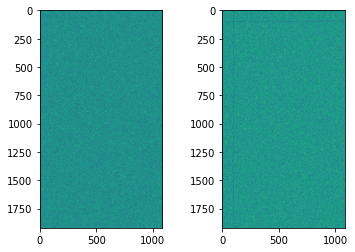

In [61]:
output = np.zeros_like(domain)

per_thread = 1

threadsperblock = (8, 16)
blockspergrid_x = math.ceil(domain.shape[0] / threadsperblock[0]/per_thread)
blockspergrid_y = math.ceil(domain.shape[1] / threadsperblock[1]/per_thread)
blockspergrid = (blockspergrid_x, blockspergrid_y)

%time conv2d[blockspergrid, threadsperblock](domain,output)
%time conv2d[blockspergrid, threadsperblock](domain,output)
%time conv2d[blockspergrid, threadsperblock](domain,output)
%time conv2d[blockspergrid, threadsperblock](domain,output)
%time conv2d[blockspergrid, threadsperblock](domain,output)
%time conv2d[blockspergrid, threadsperblock](domain,output)
plt.subplot(1,2,1)
plt.imshow(domain)
plt.subplot(1,2,2)
plt.imshow(output)
plt.show()